<img src='./B_MODEL.png'/>

# Table des Matières

## 01.Paramétrage

* A.Importations

* B.Chargement des données

* C.Description du contenu de chaque fichier

## 02.Préparation des données

* A.Séparation des données en train/test

* B.Encodage des variables catégorielles

* C.Gestion du déséquilibre des classes

* D.Normalisation des variables

## 03.Création du score métier

* A.Définition de la fonction de coût métier

* B.Intégration dans le processus de sélection de modèle

## 04.Modélisation

* A.Approche naïve (DummyClassifier)

* B.Modélisation
    
## 05.Comparaison des modèles


## 06.Validation des performances de la Régression Logistique sur le dataframe "wrapper" 


## 07.Optimisation

* A.Fine tuning du modèle choisi

* B.Évaluation après optimisation

## 08.Conclusion

* A..Résumé des résultats

* B.Points à améliorer ou à explorer à l'avenir

# 01. Paramétrage

## A. Importations

In [1]:
# Manipulation des données et calculs
import pandas as pd
import numpy as np

# modules standard
import time
import itertools
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement des données
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# rééquilibrage des classes
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import category_encoders as ce

# Modèles
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Métriques et évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, auc, make_scorer
)

# Paramètres de visualisation
sns.set_style("whitegrid")
%matplotlib inline

#Barre de chargement 
from tqdm import tqdm

#Feature Importance
import shap
import lime
from lime import lime_tabular

## B. Chargement des données

In [2]:
df_filtered_selected = pd.read_csv('Data/features_filtered.csv')
df_wrapper_selected = pd.read_csv('Data/features_wrapper.csv')
df_embedded_selected = pd.read_csv('Data/features_embedded.csv')
df_business_selected = pd.read_csv('Data/features_business_approach.csv')

## C. Description du contenus de chaque fichier

In [3]:
# Liste des dataframes et leurs noms associés
dataframes = {
    'filtered': df_filtered_selected,
    'wrapper': df_wrapper_selected,
    'embedded': df_embedded_selected,
    'business': df_business_selected
}

# Boucle pour parcourir et afficher les informations de chaque dataframe
for name, df in dataframes.items():
    print(f"\n\n{'='*20} {name.upper()} {'='*20}\n")
    print("\nInformations générales :")
    print(df.info())
    print('\n')
    print('Dimensionnalité du DataFrame')
    print('\n')
    print(df.shape)
    print("\n\n")



==================== FILTERED ====================


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8602 entries, 0 to 8601
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DAYS_EMPLOYED                  8602 non-null   int64  
 1   REGION_RATING_CLIENT           8602 non-null   int64  
 2   REGION_RATING_CLIENT_W_CITY    8602 non-null   int64  
 3   EXT_SOURCE_1                   8602 non-null   float64
 4   EXT_SOURCE_2                   8602 non-null   float64
 5   EXT_SOURCE_3                   8602 non-null   float64
 6   FLOORSMAX_AVG                  8602 non-null   float64
 7   FLAG_DOCUMENT_3                8602 non-null   int64  
 8   EXT_SOURCE_3.1                 8602 non-null   float64
 9   EXT_SOURCE_1.1                 8602 non-null   float64
 10  EXT_SOURCE_2.1                 8602 non-null   float64
 11  PAID_ON_TIME                

## D. Verification de data-leakage

In [4]:
# Cette fonction parcourt chaque DataFrame et chaque caractéristique à la recherche de corrélations élevées avec la variable cible.
def check_data_leakage(df_dict, target_variable):
    leakage_report = {}
    
    for name, df in df_dict.items():
        # On verifie que la variable cible est numérique
        if not np.issubdtype(df[target_variable].dtype, np.number):
            raise TypeError(f"La variable cible '{target_variable}' doit être numérique.")
        
        # Itérer uniquement sur les colonnes numériques
        numeric_columns = df.select_dtypes(include=np.number).columns.drop(target_variable)
        
        for feature in numeric_columns:
            correlation = df[feature].corr(df[target_variable])
            if abs(correlation) > 0.9:  # Seuil de corrélation pour indiquer une fuite potentielle
                leakage_report[name] = True
                break
        else:
            leakage_report[name] = False
    
    return pd.DataFrame.from_dict(leakage_report, orient='index', columns=['Data Leakage']).reset_index()

# Usage:
dataframes = {
    'filtered': df_filtered_selected,
    'wrapper': df_wrapper_selected,
    'embedded': df_embedded_selected,
    'business': df_business_selected
}
leakage_results_df = check_data_leakage(dataframes, 'TARGET')
leakage_results_df

,index,Data Leakage
0,filtered,False
1,wrapper,False
2,embedded,False
3,business,False


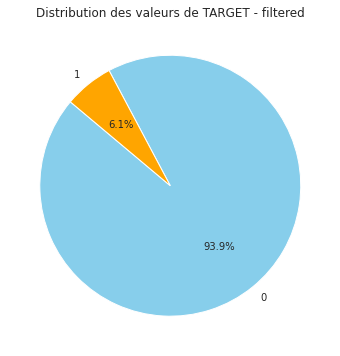

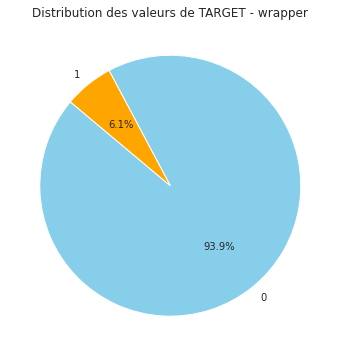

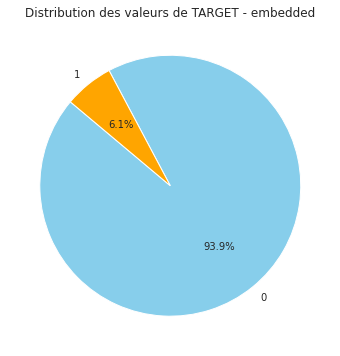

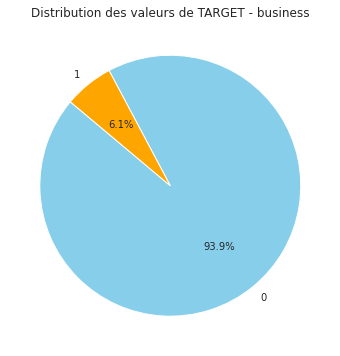

In [5]:
def show_distrubution():
    dfs = {
        'filtered': df_filtered_selected,
        'wrapper': df_wrapper_selected,
        'embedded': df_embedded_selected,
        'business': df_business_selected
    }

    # Création des diagrammes en camembert pour chaque dataframe
    for name, df in dfs.items():
        # Calcul de la distribution de la variable cible
        value_counts = df['TARGET'].value_counts()

        # Créer un diagramme en camembert
        plt.figure(figsize=(6, 6))
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
        plt.title(f'Distribution des valeurs de TARGET - {name}')
        plt.show()
        
show_distrubution()

# 02.Préparation des données

### II. Application de l'encodage OneHot sur les jeux de données

In [6]:
# Liste des noms des dataframes pour référence
df_names = ['filtered', 'wrapper', 'embedded', 'business']

encoded_dfs = {}

# Initialisation de l'encodeur One-Hot
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

for name in df_names:
    df = dataframes[name].copy()
    # Identifier les colonnes catégorielles
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    # Si aucune colonne catégorielle n'est trouvée, sautez l'encodage
    if not categorical_cols:
        print(f"Aucune colonne catégorielle trouvée dans {name}. Aucun encodage appliqué.")
        encoded_dfs[name] = df
        continue

    # Appliquer OneHotEncoder sur les colonnes catégorielles
    df_encoded = one_hot_encoder.fit_transform(df[categorical_cols])
    # Récupérer les nouvelles colonnes One-Hot
    new_columns = one_hot_encoder.get_feature_names_out(categorical_cols)
    # Supprimer les anciennes colonnes catégorielles
    df.drop(categorical_cols, axis=1, inplace=True)
    # Ajouter les nouvelles colonnes encodées au dataframe
    df_encoded = pd.DataFrame(df_encoded, columns=new_columns, index=df.index)
    df = pd.concat([df, df_encoded], axis=1)
    # Mettre à jour le dictionnaire avec le dataframe mis à jour
    encoded_dfs[name] = df
    print(f"Encodage One-Hot terminé pour {name}. Taille après encodage: {df.shape}")

Aucune colonne catégorielle trouvée dans filtered. Aucun encodage appliqué.
Aucune colonne catégorielle trouvée dans wrapper. Aucun encodage appliqué.
Aucune colonne catégorielle trouvée dans embedded. Aucun encodage appliqué.
Aucune colonne catégorielle trouvée dans business. Aucun encodage appliqué.


## A.Séparation des données en train/test

In [7]:
# Liste des dataframes et leurs noms
dfs = [df_filtered_selected, df_wrapper_selected, df_embedded_selected, df_business_selected]
df_names = ['filtered', 'wrapper', 'embedded', 'business']

# Dictionnaires pour stocker les ensembles d'entraînement et de test pour chaque dataframe
X_trains, X_tests, y_trains, y_tests = {}, {}, {}, {}

# Boucle pour séparer les données
for df, name in zip(dfs, df_names):
    X = df.drop(columns="TARGET")
    y = df["TARGET"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    X_trains[name] = X_train
    X_tests[name] = X_test
    y_trains[name] = y_train
    y_tests[name] = y_test

In [8]:
for df, name in zip(dfs, df_names):
    print('Dataframe :', name)
    print("Dimensions de X_train: ", X_train.shape)
    print("Dimensions de X_test: ", X_test.shape)


Dataframe : filtered
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : wrapper
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : embedded
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : business
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)


In [9]:
X_trains['filtered']

,DAYS_EMPLOYED,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,FLAG_DOCUMENT_3,EXT_SOURCE_3.1,EXT_SOURCE_1.1,...,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_2.2,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1.2,AMT_CREDIT_SUM_DEBT,REGION_RATING_CLIENT.2,EXT_SOURCE_3.2,EXT_SOURCE_1.3,EXT_SOURCE_2.3,FLAG_DOCUMENT_3.3
5729,-2655,2,2,0.376188,0.758812,0.513694,0.0417,1,0.513694,0.376188,...,-1669.0,0.758812,0,0.376188,1.093152e+06,2,0.513694,0.376188,0.758812,1
7029,-2385,2,2,0.863860,0.736282,0.691021,0.3333,0,0.691021,0.863860,...,0.0,0.736282,0,0.863860,0.000000e+00,2,0.691021,0.863860,0.736282,0
5250,-4118,2,2,0.725535,0.361032,0.626304,0.1667,1,0.626304,0.725535,...,-1606.0,0.361032,0,0.725535,1.086314e+06,2,0.626304,0.725535,0.361032,1
3125,-3165,2,2,0.531897,0.368612,0.231439,0.0833,0,0.231439,0.531897,...,-863.0,0.368612,0,0.531897,8.791011e+06,2,0.231439,0.531897,0.368612,0
6769,-1436,2,2,0.553932,0.689312,0.270707,0.0417,1,0.270707,0.553932,...,-815.0,0.689312,1,0.553932,2.885400e+04,2,0.270707,0.553932,0.689312,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,-2354,2,2,0.788778,0.741937,0.533482,0.3333,1,0.533482,0.788778,...,-834.0,0.741937,0,0.788778,2.137770e+05,2,0.533482,0.788778,0.741937,1
8124,-2148,2,2,0.739826,0.718796,0.554947,0.0971,1,0.554947,0.739826,...,-1830.0,0.718796,0,0.739826,1.159380e+07,2,0.554947,0.739826,0.718796,1
1536,-2344,1,1,0.735756,0.753510,0.754406,0.3333,0,0.754406,0.735756,...,-1250.0,0.753510,0,0.735756,0.000000e+00,1,0.754406,0.735756,0.753510,0
2883,-4857,2,2,0.689807,0.742317,0.616122,0.1250,1,0.616122,0.689807,...,0.0,0.742317,0,0.689807,2.064023e+06,2,0.616122,0.689807,0.742317,1


## C.Gestion du déséquilibre des classes avec SMOTE

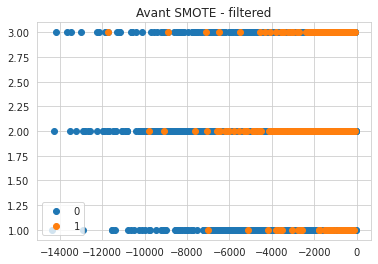

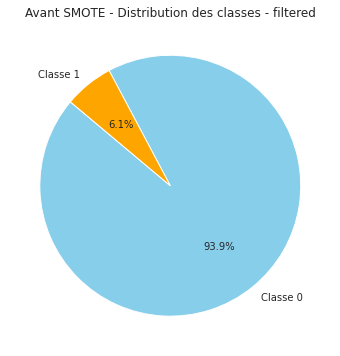

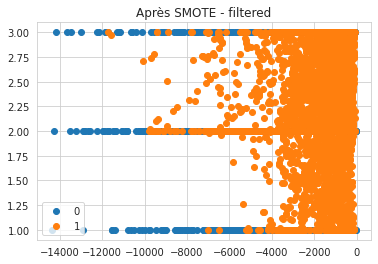

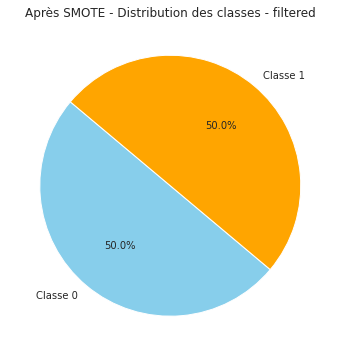

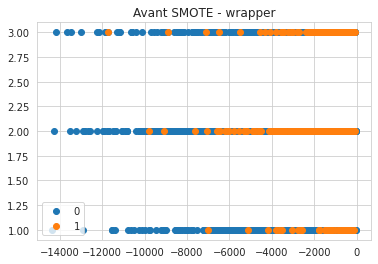

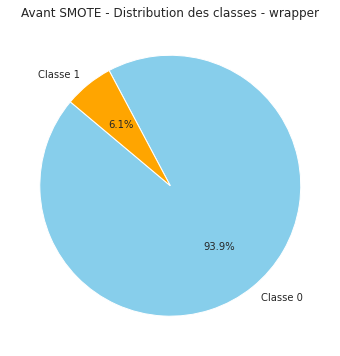

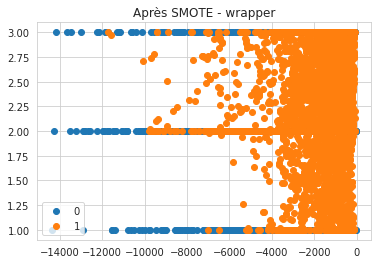

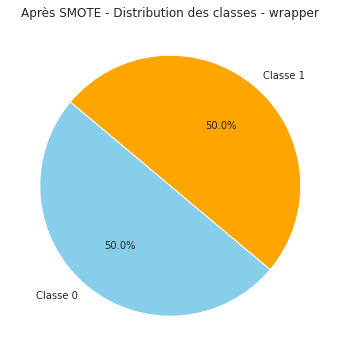

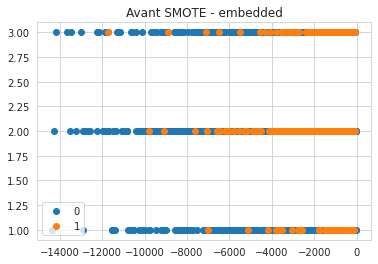

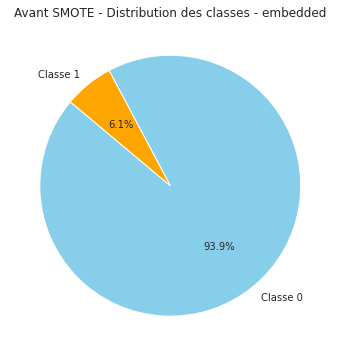

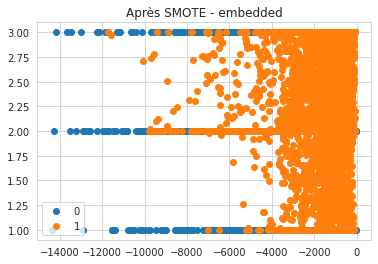

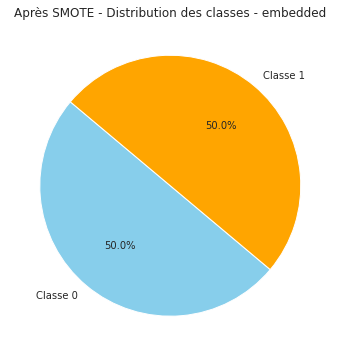

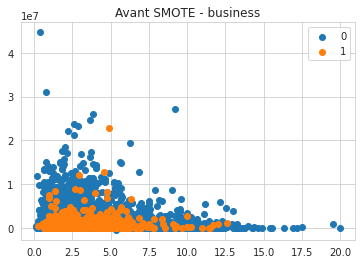

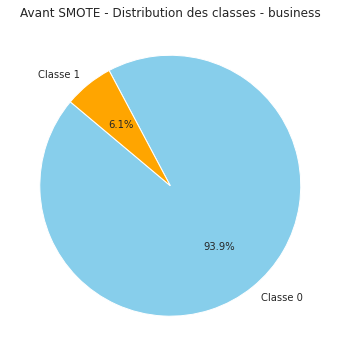

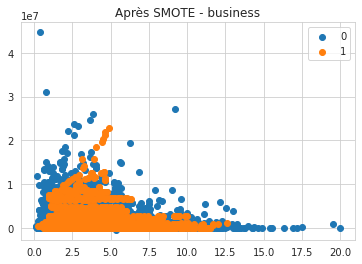

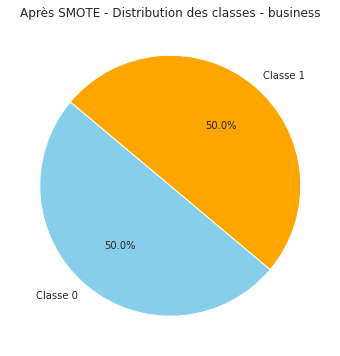

In [10]:
# Fonction pour afficher le scatter plot
def plot_classes(X, y, title):
    counter = Counter(y)
    for label, _ in counter.items():
        row_ix = [i for i, v in enumerate(y) if v == label]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.title(title)
    plt.legend()
    plt.show()
    
# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(y, title):
    counter = Counter(y)
    sizes = [counter[0], counter[1]]
    labels = 'Classe 0', 'Classe 1'
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    plt.title(title)
    plt.show()


for name in df_names:
    if name in X_trains and name in y_trains:
        X_train = X_trains[name]
        y_train = y_trains[name]
        # Convertir en numpy array si nécessaire
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        # Afficher les données avant SMOTE
        plot_classes(X_train, y_train, f"Avant SMOTE - {name}")
        plot_pie_chart(y_train, f"Avant SMOTE - Distribution des classes - {name}")
        # Application de SMOTE
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        # Mettre à jour les dictionnaires avec les données resamplées
        X_trains[name] = X_train_smote
        y_trains[name] = y_train_smote
        # Afficher les données après SMOTE
        plot_classes(X_train_smote, y_train_smote, f"Après SMOTE - {name}")
        plot_pie_chart(y_train_smote, f"Après SMOTE - Distribution des classes - {name}")
    else:
        print(f"Le nom de dataset '{name}' n'est pas dans les dictionnaires X_trains ou y_trains.")


In [11]:
for df, name in zip(dfs, df_names):
    print('Dataframe :', name)
    print("Dimensions de X_train: ", X_train.shape)
    print("Dimensions de X_test: ", X_test.shape)


Dataframe : filtered
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : wrapper
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : embedded
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : business
Dimensions de X_train:  (6881, 8)
Dimensions de X_test:  (1721, 8)


Les vérifications ont démontré que l'application de SMOTE a correctement rééquilibré les classes pour chaque ensemble de données. 

Pour les quatre groupes de caractéristiques (filtered, wrapper, embedded, business), nous observons une distribution égale des classes avec 5651 instances dans chaque classe. 

Cela indique que l'étape de rééquilibrage avec SMOTE a été exécutée avec succès, permettant ainsi de procéder aux étapes suivantes de modélisation avec des classes équilibrées

## D.Normalisation des variables

In [12]:
# Initialisation du StandardScaler
scaler = StandardScaler()

# Dictionnaire pour stocker les résultats
normalization_results = {
    "dataset": [],
    "mean_first_feature": [],
    "std_first_feature": [],
    "mean_second_feature": [],
    "std_second_feature": [],
}

# Boucle sur chaque dataframe pour normaliser les données
scalers = {}
for name in df_names:
        
    scaler = StandardScaler()
    X_train = X_trains[name]
    scaler.fit(X_train)
    scalers[name] = scaler   

    X_train = X_trains[name]
    X_test = X_tests[name]

    # Calculer la moyenne et l'écart type sur l'ensemble d'entraînement
    scaler.fit(X_train)

    # Appliquer la normalisation sur l'ensemble d'entraînement et de test
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Remplacer les ensembles originaux par les ensembles normalisés
    X_trains[name] = X_train_scaled
    X_tests[name] = X_test_scaled

    # Stocker les résultats pour la première et la seconde caractéristique
    normalization_results["dataset"].append(name)
    normalization_results["mean_first_feature"].append(X_train_scaled[:, 0].mean())
    normalization_results["std_first_feature"].append(X_train_scaled[:, 0].std())
    normalization_results["mean_second_feature"].append(X_train_scaled[:, 1].mean())
    normalization_results["std_second_feature"].append(X_train_scaled[:, 1].std())
    

normalization_results_df = pd.DataFrame(normalization_results)
normalization_results_df

,dataset,mean_first_feature,std_first_feature,mean_second_feature,std_second_feature
0,filtered,1.575073e-15,1.0,9.644023e-15,1.0
1,wrapper,1.575073e-15,1.0,9.644023e-15,1.0
2,embedded,1.575073e-15,1.0,9.644023e-15,1.0
3,business,-3.811193e-15,1.0,2.463801e-16,1.0


Nous avons réussi à normaliser avec succès les ensembles de données 'filtered', 'wrapper', 'embedded' et 'business'. 

Les moyennes des caractéristiques pour chaque ensemble de données sont très proches de zéro et les écarts types sont équivalents à 1. 

Cela confirme que la normalisation a été effectuée correctement et que nos données sont désormais prêtes pour les étapes de modélisation qui nécessitent des caractéristiques mises à l'échelle.

# 03.Définition des  fonctions d'evaluations

In [13]:
def business_cost_function(y_true, y_proba, cost_fp=1, cost_fn=10):
    if y_proba.ndim == 1:
        y_proba = np.vstack((1 - y_proba, y_proba)).T
    elif y_proba.shape[1] == 1:
        y_proba = np.hstack((1 - y_proba, y_proba))
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
    costs = []
    for threshold in thresholds:
        y_pred = (y_proba[:, 1] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = cost_fp * fp + cost_fn * fn
        costs.append((threshold, cost))
    min_cost_threshold = min(costs, key=lambda x: x[1])
    return min_cost_threshold[1], min_cost_threshold[0]

In [14]:
#Cette fonction est un score personnalisé pour GridSearchCV qui utilise le coût métier.
def business_scorer(y_true, y_pred_proba, cost_fp=1, cost_fn=10):
    business_cost, _ = business_cost_function(y_true, y_pred_proba, cost_fp, cost_fn)
    return -business_cost  # GridSearchCV maximise le score donc on retourne le coût négatif

In [15]:
# Cette fonction affiche les scores de performance du modèle sur les ensembles d'entraînement et de test.
def score(estimator):
    
    # Calcul du score sur l'ensemble d'entraînement (train)
    tr_score = estimator.score(X_train, Y_train).round(4)
    # Calcul du score sur l'ensemble de test (test)
    te_score = estimator.score(X_test, Y_test).round(4)
    # Affichage des scores d'entraînement et de test
    print(f"score train : {tr_score} score de test : {te_score}")

In [16]:
# Cette fonction génère une matrice de confusion
def confusion(Y_test, y_pred):
    mat = confusion_matrix(Y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

In [17]:
def calcul_auc_roc(y_true, y_pred_proba):
    """
    Calcule l'AUC de la courbe ROC pour évaluer la qualité des prédictions d'un modèle.
    
    :param y_true: Tableau des étiquettes vraies.
    :param y_pred_proba: Tableau des probabilités prédites pour la classe positive.
    :return: Tuple contenant les taux de faux positifs, les taux de vrais positifs et l'AUC.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [18]:
# Cette fonction génère et affiche la courbe ROC
def courbe_roc(false_positive_rate, true_positive_rate, roc_auc):
    plt.figure(figsize=(10, 10))
    plt.title('Caractéristique de Fonctionnement du Récepteur')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('Taux de Vrais Positifs')
    plt.xlabel('Taux de Faux Positifs')
    plt.show()

In [19]:
# Cette fonction calcule l'AUC de la courbe Precision-Recall
def calcul_auc_pr(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    return precision, recall, pr_auc

In [20]:
def calcul_gain_cumulatif(y_true, y_pred_proba):
    """
    Calcul le Gain Cumulatif pour les prédictions d'un modèle.
    Le Gain Cumulatif compare le nombre de cas positifs capturés par le modèle
    par rapport à une sélection aléatoire.
    """
    y_true = y_true.reset_index(drop=True)
    sorted_proba = np.argsort(y_pred_proba)[::-1]
    sorted_true = y_true[sorted_proba]
    cumulative_gain = np.cumsum(sorted_true) / np.sum(y_true)
    percentage = np.arange(1, len(cumulative_gain) + 1) / len(y_true)
    return percentage, cumulative_gain


# 04.Modélisation

## A. Approche naïve (DummyClassifier)

In [21]:
dummy_results = []

for name in tqdm(df_names, desc="Progression"):
    print(f"Évaluation de l'approche naïve pour {name}...")
    
    # Charger les données
    X_train = X_trains[name]
    y_train = y_trains[name]
    X_test = X_tests[name]
    y_test = y_tests[name]
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Création et entraînement du DummyClassifier
    dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
    dummy_clf.fit(X_train, y_train)
    
    # Prédire sur l'ensemble de test
    y_pred = dummy_clf.predict(X_test)
    y_pred_proba = dummy_clf.predict_proba(X_test)[:, 1]
    
    # Arrêter le chronomètre
    end_time = time.time()
    
    # Calcul du temps écoulé
    elapsed_time = time.strftime("%M:%S", time.gmtime(end_time - start_time))
    
    # Métriques pour le graphique ROC
    fpr, tpr, roc_auc = calcul_auc_roc(y_test, y_pred_proba)
    
    dummy_results.append({
        "dataset": name,
        "model": "Dummy",
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc,
        "business_cost": business_cost_function(y_test, y_pred_proba)[0],
        "roc_curve": (fpr, tpr),
        "elapsed_time": elapsed_time
    })

dummy_df = pd.DataFrame(dummy_results)
dummy_df

Progression: 100%|██████████| 4/4 [00:00<00:00, 102.04it/s]

Évaluation de l'approche naïve pour filtered...
Évaluation de l'approche naïve pour wrapper...
Évaluation de l'approche naïve pour embedded...
Évaluation de l'approche naïve pour business...


,dataset,model,accuracy,precision,recall,f1_score,roc_auc,business_cost,roc_curve,elapsed_time
0,filtered,Dummy,0.938989,0.0,0.0,0.0,0.5,1050,"([0.0, 1.0], [0.0, 1.0])",00:00
1,wrapper,Dummy,0.938989,0.0,0.0,0.0,0.5,1050,"([0.0, 1.0], [0.0, 1.0])",00:00
2,embedded,Dummy,0.938989,0.0,0.0,0.0,0.5,1050,"([0.0, 1.0], [0.0, 1.0])",00:00
3,business,Dummy,0.938989,0.0,0.0,0.0,0.5,1050,"([0.0, 1.0], [0.0, 1.0])",00:00


**Conclusion sur l'Évaluation de l'Approche Naïve avec DummyClassifier :**

**Précision (Accuracy):**

- L'accuracy élevée de 93.96% reflète la prévalence de la classe majoritaire. Cela indique que, sans apprendre des caractéristiques, le modèle prédit la classe majoritaire dans une grande majorité des cas.

**Précision (Precision) et Rappel (Recall) :**

- La précision et le rappel sont tous deux à 0, indiquant que le modèle n'a pas correctement identifié un seul vrai positif. Cela démontre l'incapacité du modèle à capturer la classe minoritaire, ce qui est critique dans de nombreux contextes opérationnels.

**Score F1 (F1 Score):**

- Un score F1 de 0 souligne l'échec complet du modèle à équilibrer la précision et le rappel, ce qui est crucial lorsque les deux métriques sont importantes pour l'application.

**AUC-ROC (Area Under the Receiver Operating Characteristic Curve):**

- Un score ROC AUC de 0.5 montre que le modèle n'a aucune capacité discriminatoire au-delà du hasard. C'est un indicateur que le modèle ne peut pas distinguer entre les classes positives et négatives.

**Business Cost:**

- Le coût métier élevé suggère que le modèle serait coûteux à utiliser dans la pratique, en raison du grand nombre de faux négatifs générés par la prédiction constante de la classe majoritaire.

**Scores de Train et Test:**

- Les scores de train et test identiques reflètent l'absence d'apprentissage. Cela montre que le modèle ne généralise pas au-delà de la simple prédiction de la classe la plus fréquente.

**Matrice de Confusion:**

- La matrice de confusion montre une absence totale de vrai positif, ce qui confirme l'incapacité du modèle à identifier les cas positifs.

**Temps de Calcul:**

- Le temps de calcul très court reflète la simplicité du modèle qui ne nécessite pas de processus d'apprentissage.

Les métriques de performance du DummyClassifier soulignent son inaptitude à fournir une classification utile au-delà de la simple prédiction de la classe majoritaire.

Tout modèle significatif devrait surpasser ces métriques pour être considéré comme efficace. 

Les résultats servent de référence pour évaluer la performance des modèles plus complexes, qui doivent démontrer leur capacité à apprendre des données et à identifier correctement les instances de chaque classe, tout en gérant efficacement les coûts associés aux prédictions incorrectes.

## B. Modelisation

### I. Évaluation des Performances des Modèles sur Différents Ensembles de Données

In [22]:
for df, name in zip(dfs, df_names):
    print('Dataframe :', name)
    print("Dimensions de X_train: ", X_train.shape)
    print("Dimensions de X_test: ", X_test.shape)


Dataframe : filtered
Dimensions de X_train:  (12920, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : wrapper
Dimensions de X_train:  (12920, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : embedded
Dimensions de X_train:  (12920, 8)
Dimensions de X_test:  (1721, 8)
Dataframe : business
Dimensions de X_train:  (12920, 8)
Dimensions de X_test:  (1721, 8)


In [23]:
# Définition des grilles d'hyperparamètres
param_grids = {
    "Decision Tree": {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "MLP Classifier": {"alpha": [1e-2, 1e-1, 1], "hidden_layer_sizes": [(10, 10, 5, 2), (20, 10, 5)]},
    "SVM": {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01]},
    "Logistic Regression": {"Cs": [10, 100, 1000], "cv": [5, 10]}
}

# Initialisation des modèles
models = [
    {"name": "Logistic Regression", "clf": LogisticRegressionCV(), "param_grid": param_grids["Logistic Regression"]},
    {"name": "Decision Tree", "clf": DecisionTreeClassifier(), "param_grid": param_grids["Decision Tree"]},
    {"name": "Random Forest", "clf": RandomForestClassifier(), "param_grid": param_grids["Random Forest"]},
    {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(), "param_grid": param_grids["Gradient Boosting"]},
    {"name": "MLP Classifier", "clf": MLPClassifier(max_iter=500, random_state=42), "param_grid": param_grids["MLP Classifier"]},
    {"name": "SVM", "clf": SVC(probability=True, kernel='linear', random_state=42, cache_size=700), "param_grid": param_grids["SVM"]},
    {"name": "Naive Bayes", "clf": GaussianNB(), "param_grid": None}
]

# Stockage des résultats
results = []

for dataset_name in ['filtered', 'wrapper', 'embedded', 'business']:
    X_train = X_trains[dataset_name]
    X_test = X_tests[dataset_name]
    y_train, y_test = y_trains[dataset_name], y_tests[dataset_name]
    
    for model in tqdm(models, desc=f"Training Models - {dataset_name}"):
        start_time = time.time()

        # Utilisation de GridSearchCV
        if model.get("param_grid"):
            grid_search = GridSearchCV(model["clf"], model["param_grid"], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_clf = grid_search.best_estimator_
        else:
            best_clf = model["clf"]
            best_clf.fit(X_train, y_train)

        y_pred = best_clf.predict(X_test)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        # Métriques pour le graphique ROC
        fpr, tpr, roc_auc = calcul_auc_roc(y_test, y_pred_proba)

        results.append({
            'model': model['name'],
            'dataset': dataset_name,
            'train_accuracy': best_clf.score(X_train, y_train),
            'test_accuracy': best_clf.score(X_test, y_test),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'business_cost': business_cost_function(y_test, y_pred_proba)[0],
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist(),
            'elapsed_time': time.time() - start_time,
            'best_model': best_clf,
        })

results_df = pd.DataFrame(results)
results_df

Training Models - business: 100%|██████████| 7/7 [17:29<00:00, 150.00s/it]


,model,dataset,train_accuracy,test_accuracy,precision,recall,f1_score,roc_auc,business_cost,fpr,tpr,elapsed_time,best_model
0,Logistic Regression,filtered,0.706269,0.679837,0.112847,0.619048,0.190896,0.736315,810,"[0.0, 0.0006188118811881188, 0.004331683168316...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",202.016232,LogisticRegressionCV(cv=10)
1,Decision Tree,filtered,0.912616,0.846020,0.111650,0.219048,0.147910,0.647186,951,"[0.0, 0.009900990099009901, 0.0105198019801980...","[0.0, 0.0380952380952381, 0.047619047619047616...",1.797463,"DecisionTreeClassifier(max_depth=10, min_sampl..."
2,Random Forest,filtered,1.000000,0.915166,0.098039,0.047619,0.064103,0.678188,911,"[0.0, 0.0006188118811881188, 0.003712871287128...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.019047...",35.716006,"(DecisionTreeClassifier(max_features='auto', r..."
3,Gradient Boosting,filtered,0.971749,0.921557,0.142857,0.057143,0.081633,0.705169,908,"[0.0, 0.0006188118811881188, 0.001237623762376...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",112.080888,([DecisionTreeRegressor(criterion='friedman_ms...
4,MLP Classifier,filtered,0.910604,0.830331,0.098712,0.219048,0.136095,0.599281,989,"[0.0, 0.0006188118811881188, 0.004331683168316...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",81.335152,"MLPClassifier(alpha=0.1, hidden_layer_sizes=(2..."
5,SVM,filtered,0.709520,0.665311,0.106845,0.609524,0.181818,0.734824,817,"[0.0, 0.0006188118811881188, 0.004950495049504...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",1486.239239,"SVC(C=10, cache_size=700, gamma=1, kernel='lin..."
6,Naive Bayes,filtered,0.713545,0.648460,0.092834,0.542857,0.158554,0.679674,918,"[0.0, 0.0006188118811881188, 0.003712871287128...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",0.343672,GaussianNB()
7,Logistic Regression,wrapper,0.706269,0.679837,0.112847,0.619048,0.190896,0.736315,810,"[0.0, 0.0006188118811881188, 0.004331683168316...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",203.058543,LogisticRegressionCV(cv=10)
8,Decision Tree,wrapper,0.912539,0.846601,0.108374,0.209524,0.142857,0.642356,952,"[0.0, 0.008663366336633664, 0.0092821782178217...","[0.0, 0.02857142857142857, 0.0380952380952381,...",1.752160,"DecisionTreeClassifier(max_depth=10, min_sampl..."
9,Random Forest,wrapper,1.000000,0.915747,0.115385,0.057143,0.076433,0.675922,920,"[0.0, 0.0006188118811881188, 0.001856435643564...","[0.0, 0.0, 0.0, 0.0, 0.009523809523809525, 0.0...",32.227331,"(DecisionTreeClassifier(max_features='auto', r..."


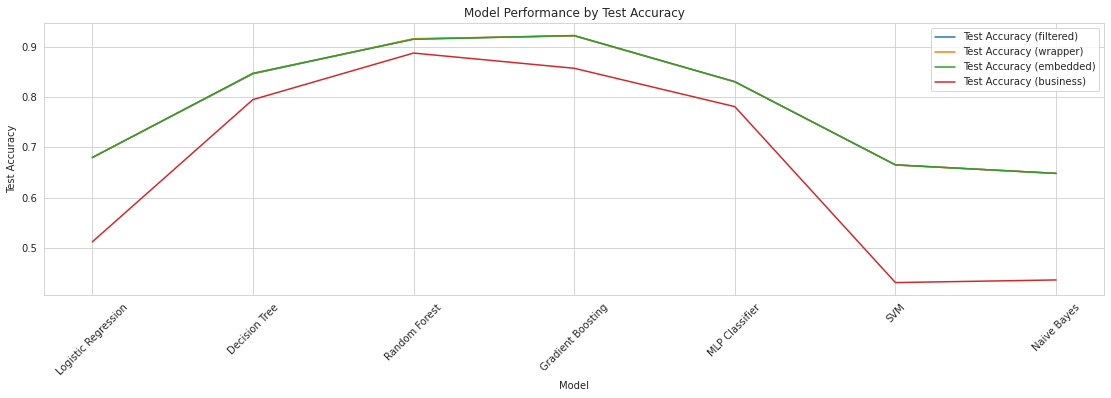

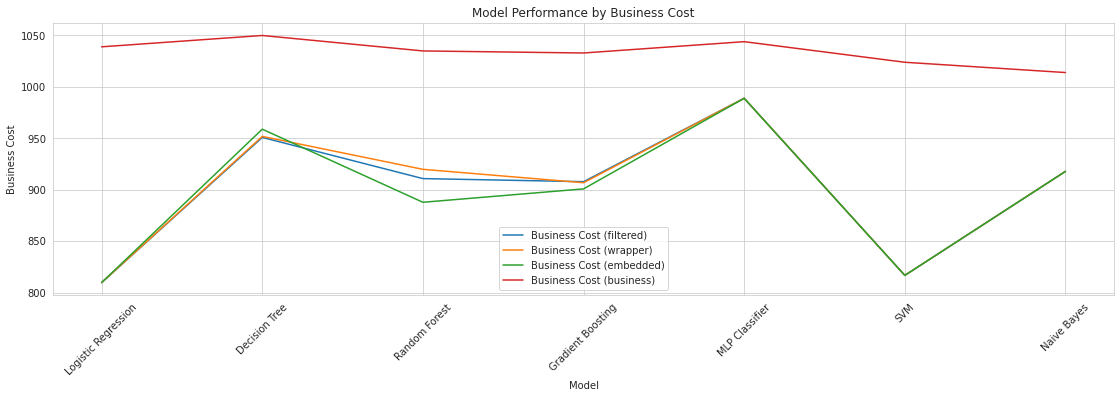

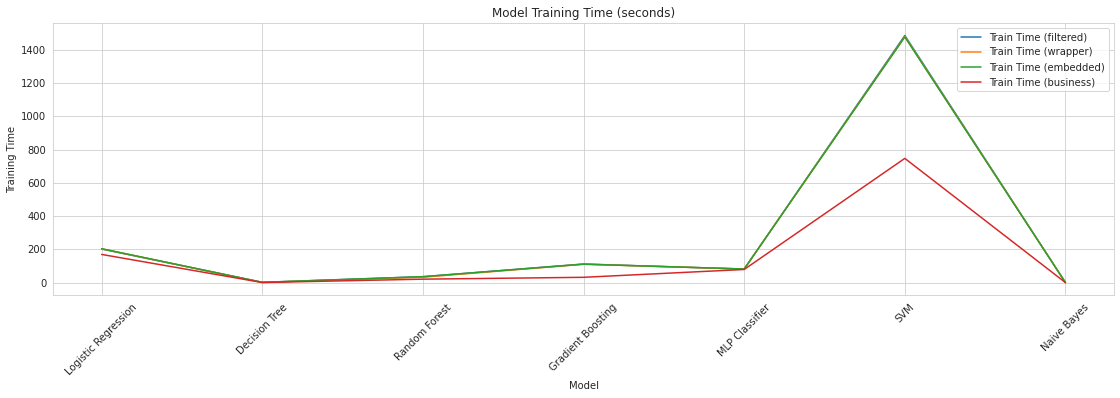

In [24]:
model_performance = []
for index, row in results_df.iterrows():
    model_performance.append({
        "model": row['model'],
        "dataset": row['dataset'],
        "train_accuracy": row['train_accuracy'],
        "test_accuracy": row['test_accuracy'],
        "train_time": row['elapsed_time'],
        "business_cost": row['business_cost']
    })

model_performance_df = pd.DataFrame(model_performance)

# Visualisation des performances des modèles
plt.figure(figsize=(19, 5))
for dataset in model_performance_df['dataset'].unique():
    subset = model_performance_df[model_performance_df['dataset'] == dataset]
    plt.plot(subset['model'], subset['test_accuracy'], label=f'Test Accuracy ({dataset})')
plt.title("Model Performance by Test Accuracy")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Visualisation des coûts métier des modèles
plt.figure(figsize=(19, 5))
for dataset in model_performance_df['dataset'].unique():
    subset = model_performance_df[model_performance_df['dataset'] == dataset]
    plt.plot(subset['model'], subset['business_cost'], label=f'Business Cost ({dataset})')
plt.title("Model Performance by Business Cost")
plt.xlabel("Model")
plt.ylabel("Business Cost")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Visualisation du temps d'entraînement des modèles
plt.figure(figsize=(19, 5))
for dataset in model_performance_df['dataset'].unique():
    subset = model_performance_df[model_performance_df['dataset'] == dataset]
    plt.plot(subset['model'], subset['train_time'], label=f'Train Time ({dataset})')
plt.title("Model Training Time (seconds)")
plt.xlabel("Model")
plt.ylabel("Training Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Courbe roc pour : filtered


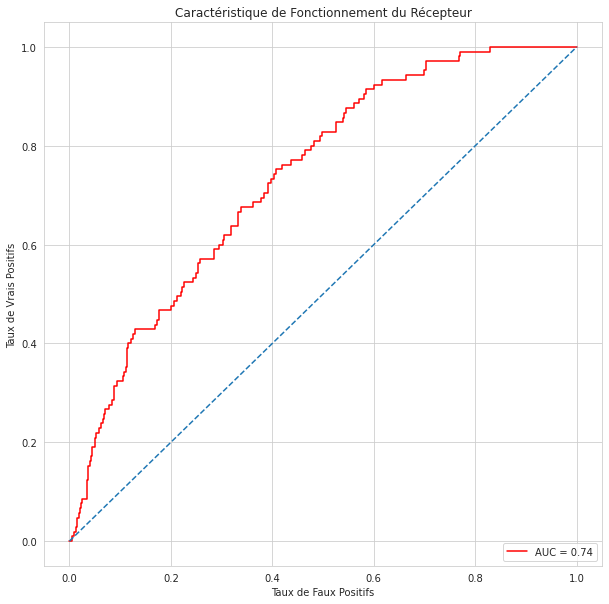

Courbe roc pour : filtered


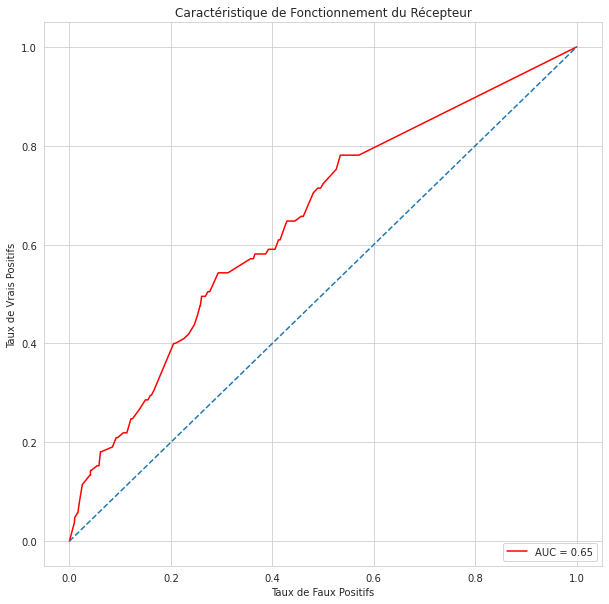

Courbe roc pour : filtered


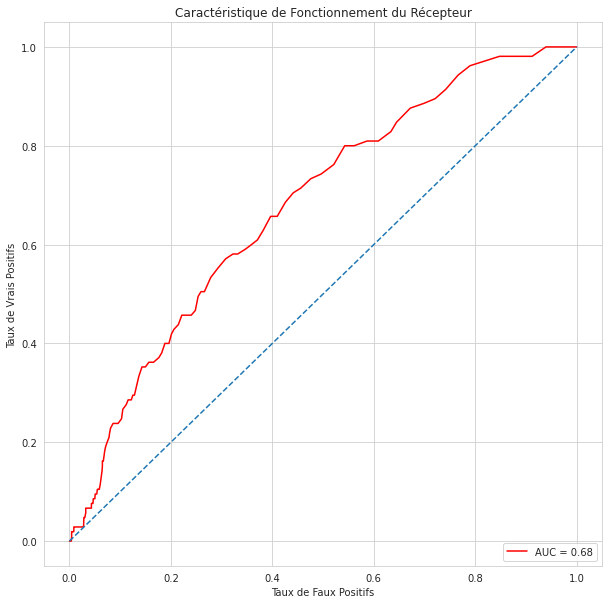

Courbe roc pour : filtered


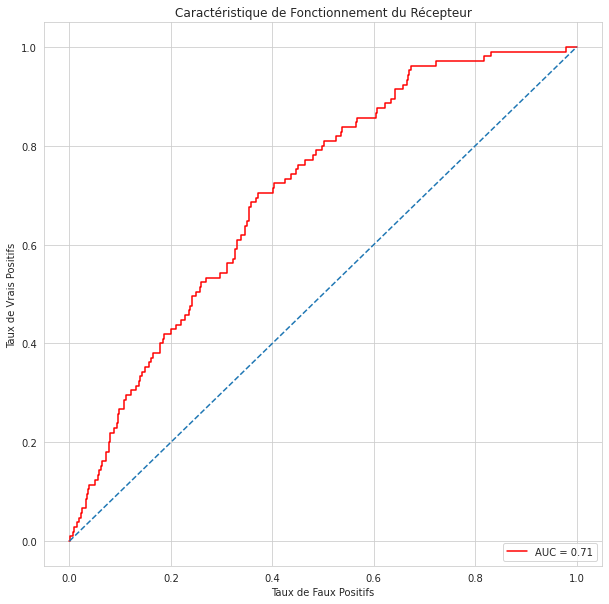

Courbe roc pour : filtered


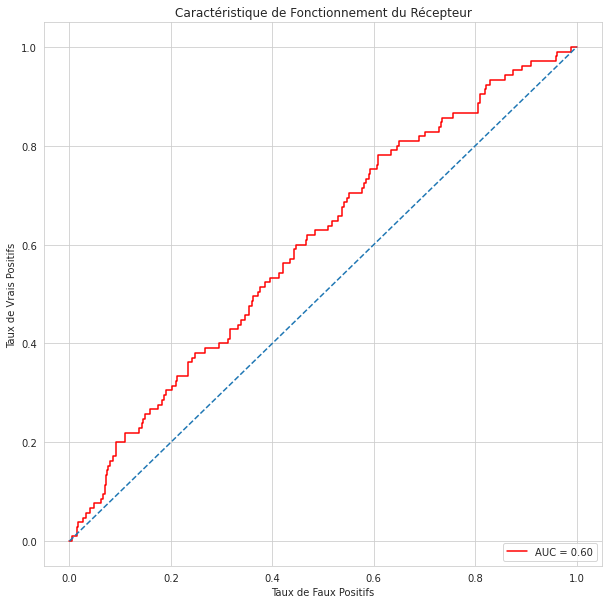

Courbe roc pour : filtered


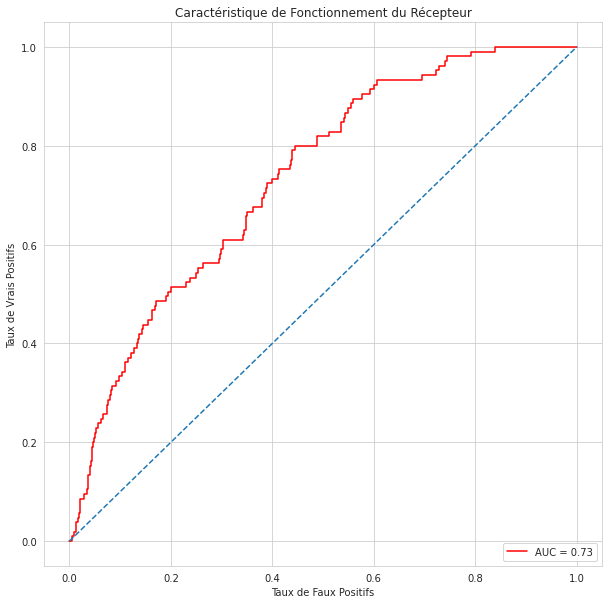

Courbe roc pour : filtered


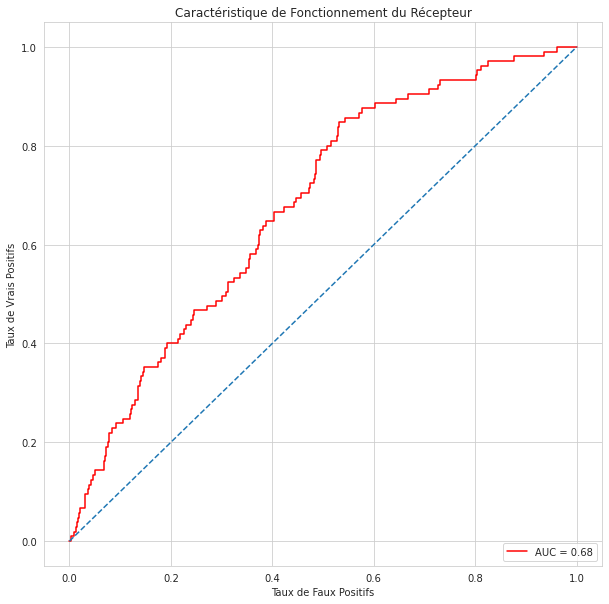

Courbe roc pour : wrapper


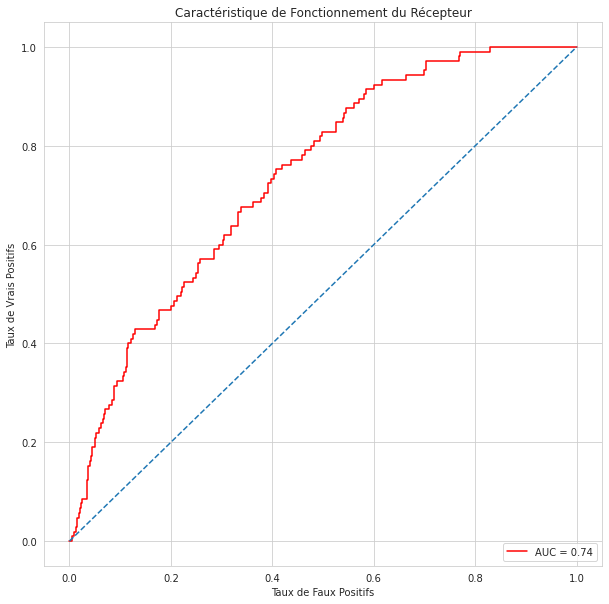

Courbe roc pour : wrapper


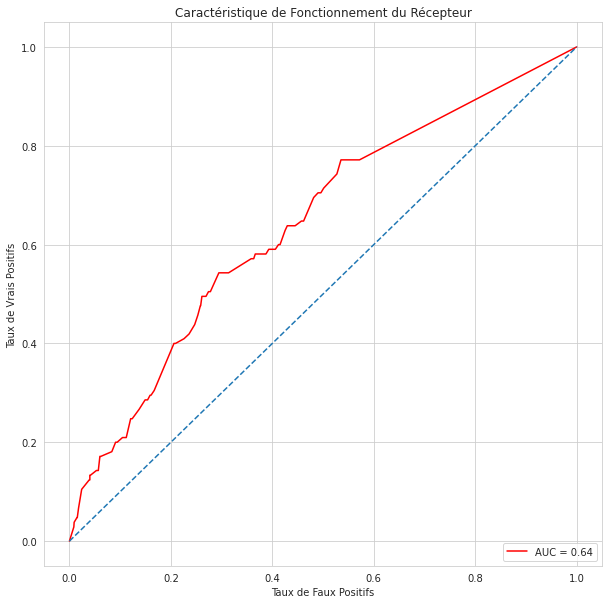

Courbe roc pour : wrapper


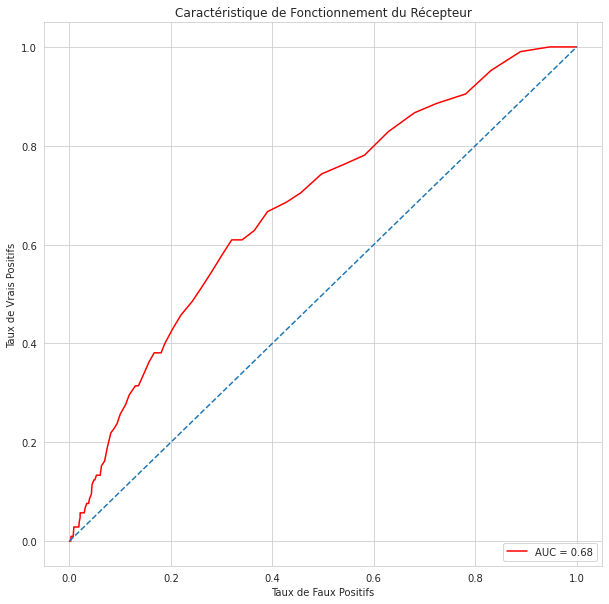

Courbe roc pour : wrapper


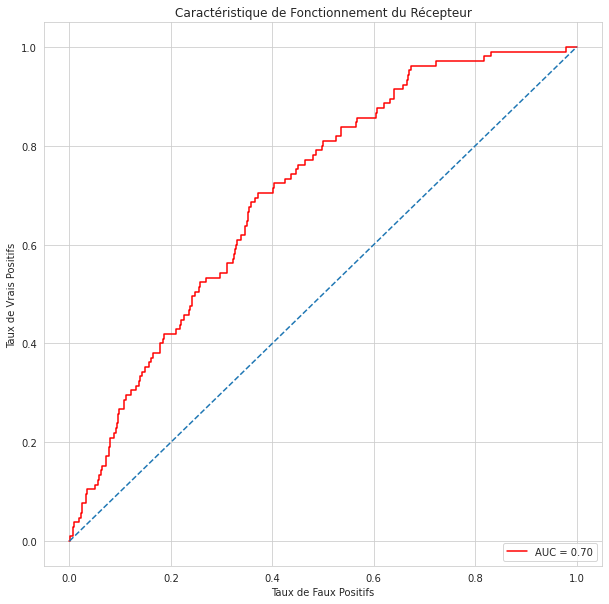

Courbe roc pour : wrapper


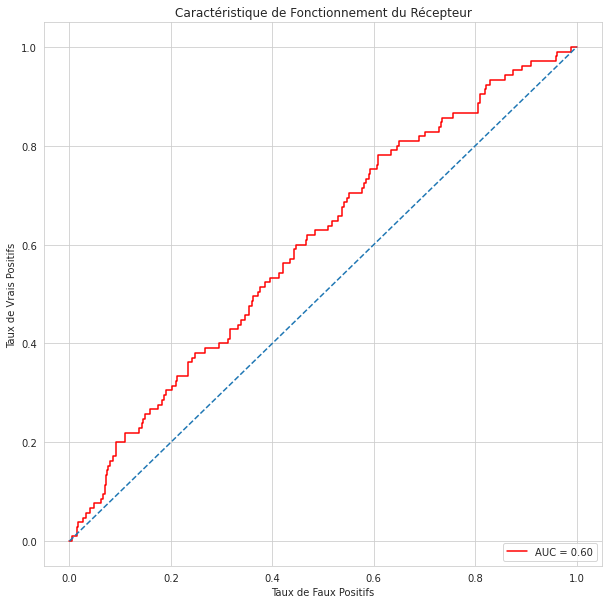

Courbe roc pour : wrapper


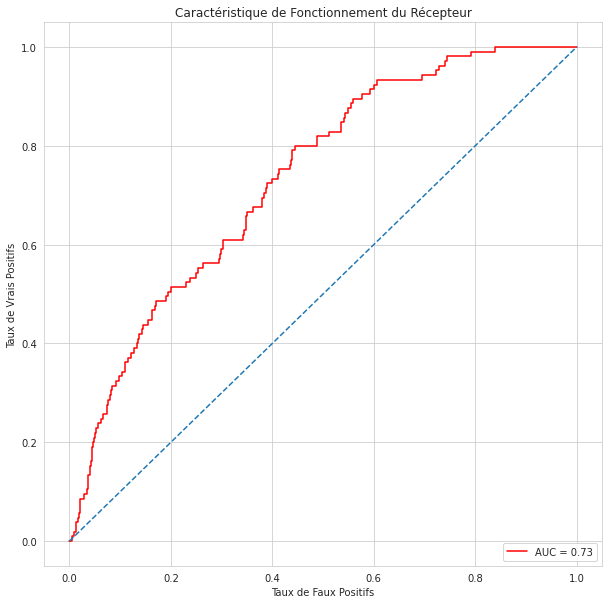

Courbe roc pour : wrapper


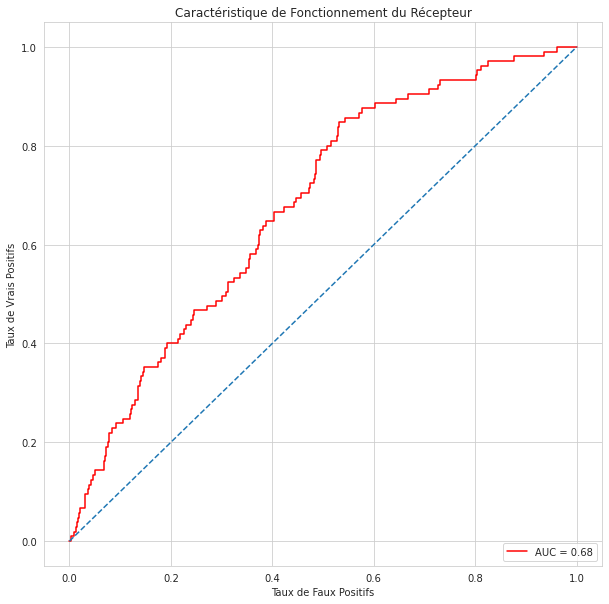

Courbe roc pour : embedded


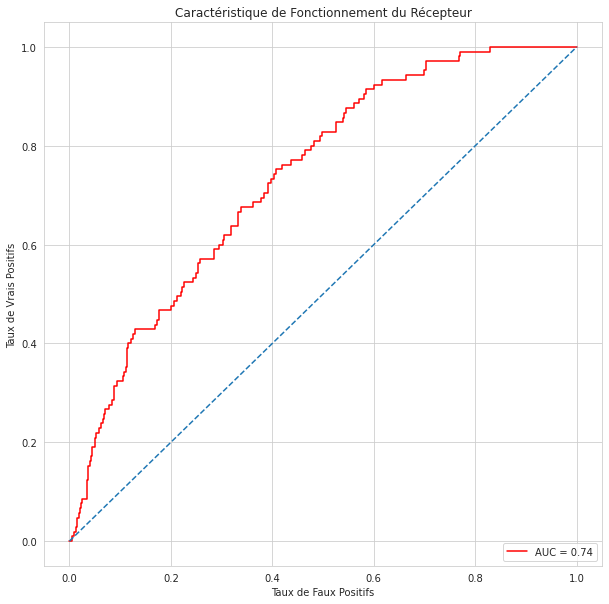

Courbe roc pour : embedded


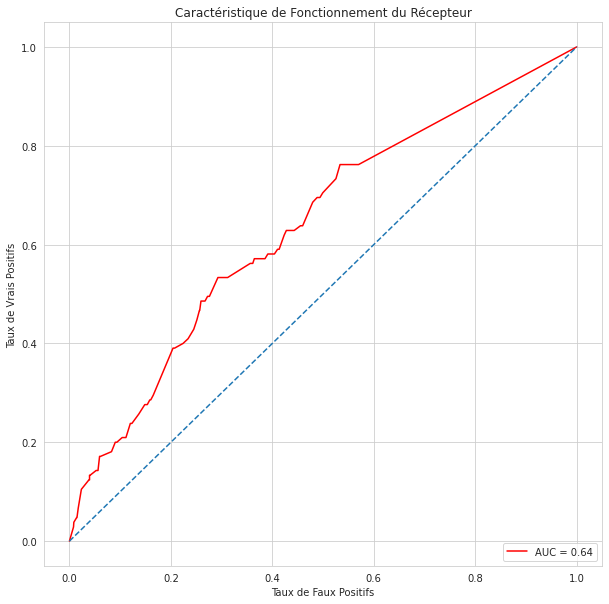

Courbe roc pour : embedded


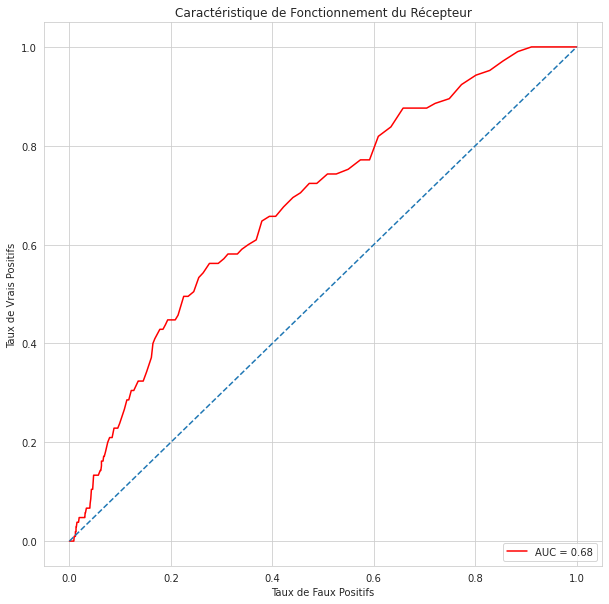

Courbe roc pour : embedded


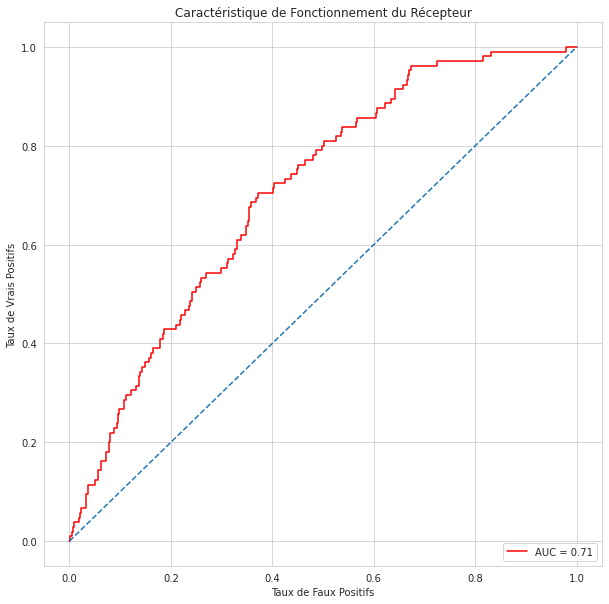

Courbe roc pour : embedded


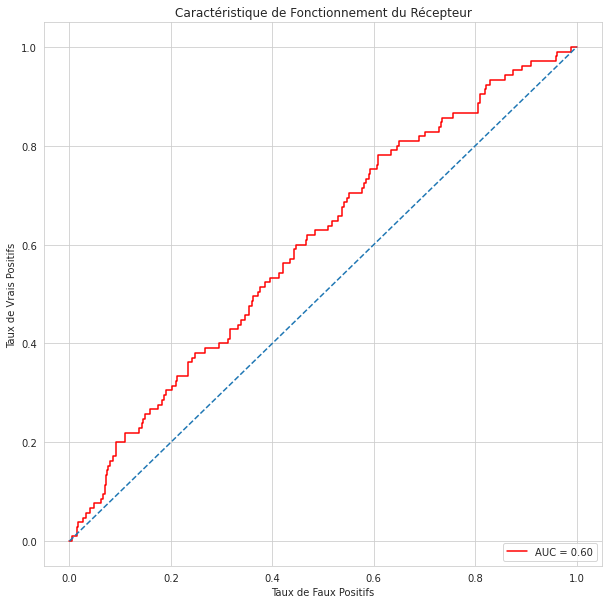

Courbe roc pour : embedded


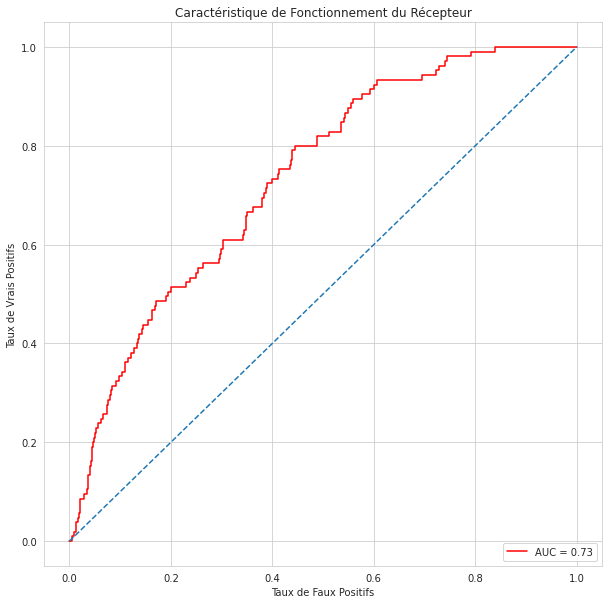

Courbe roc pour : embedded


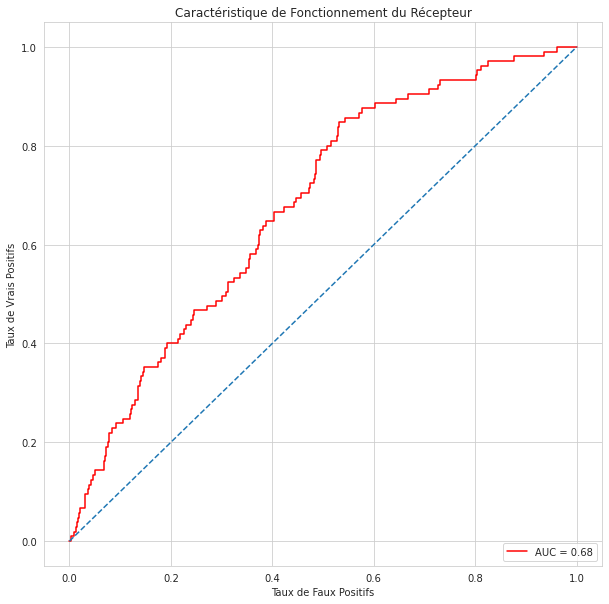

Courbe roc pour : business


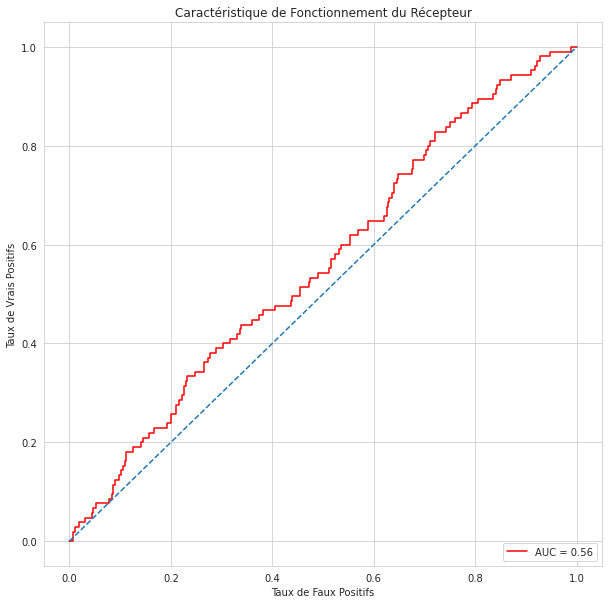

Courbe roc pour : business


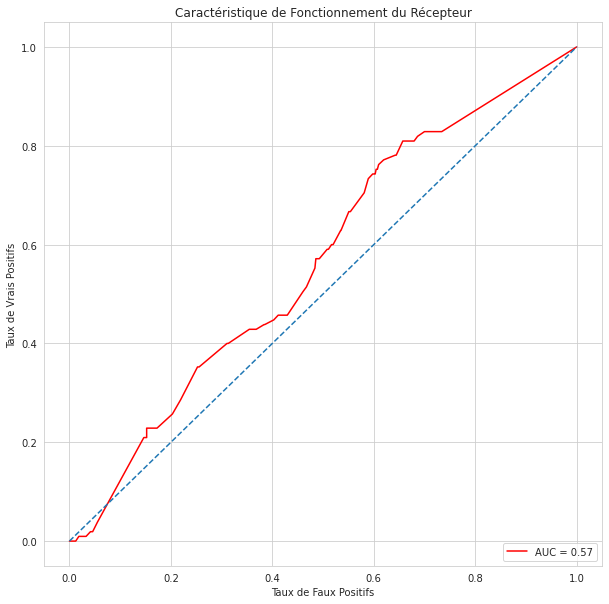

Courbe roc pour : business


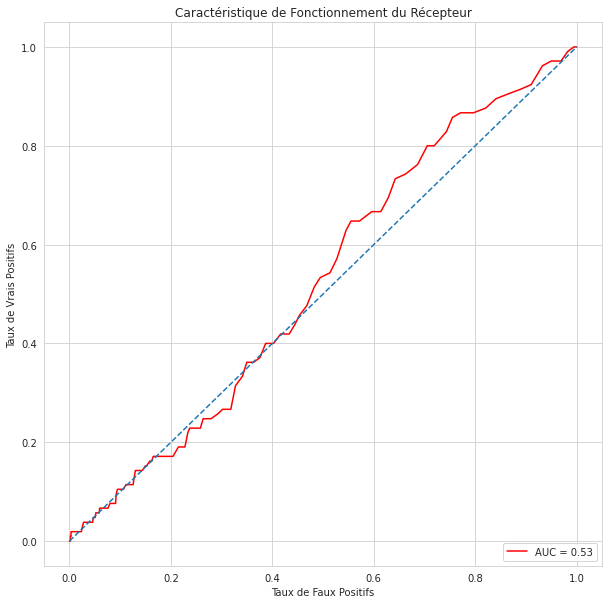

Courbe roc pour : business


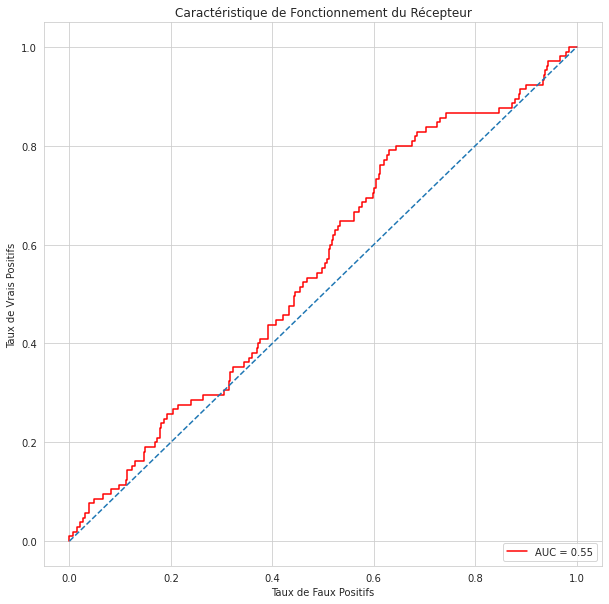

Courbe roc pour : business


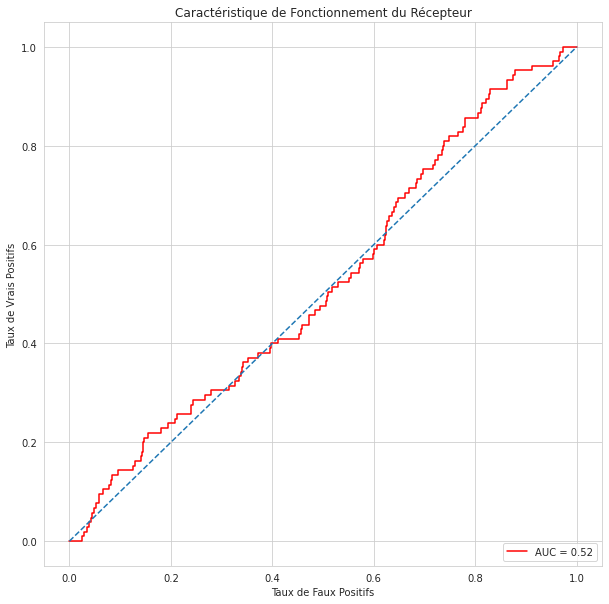

Courbe roc pour : business


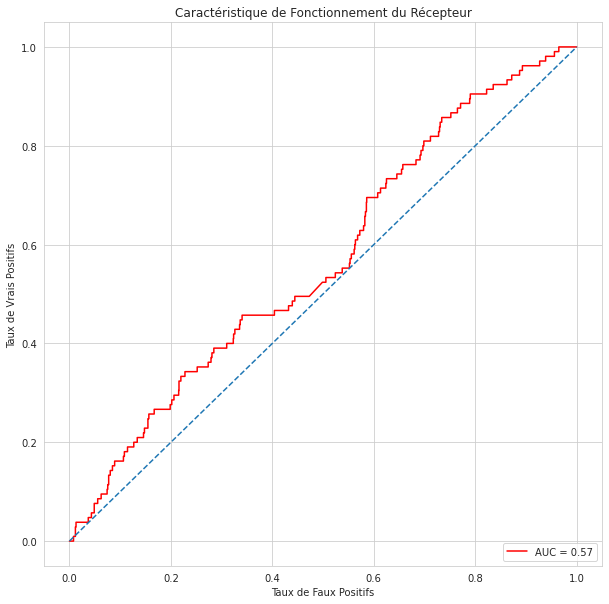

Courbe roc pour : business


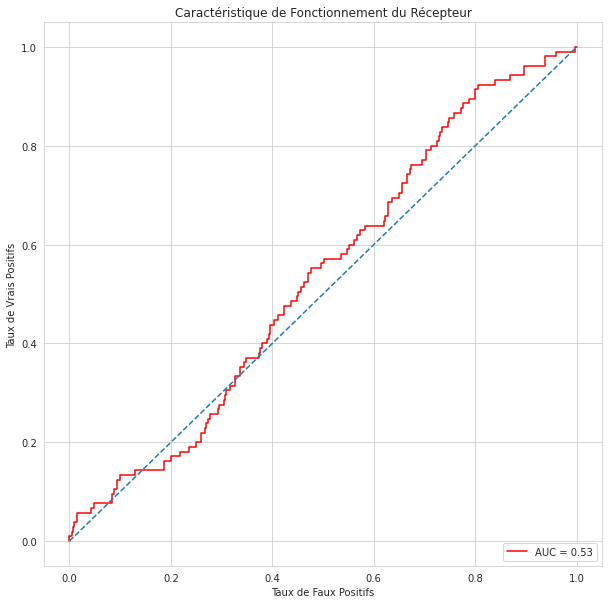

In [25]:
# Tracé des courbes ROC pour chaque modèle
for index, row in results_df.iterrows():
    fpr = row["fpr"]
    tpr = row["tpr"]
    roc_auc = row["roc_auc"]
    model_name = row["model"]
    dataset_name = row["dataset"]
    print('Courbe roc pour :', dataset_name)
    courbe_roc(fpr, tpr, roc_auc)

> #### Conclusions : 

Après une analyse approfondie et comparative des différents modèles de machine learning sur plusieurs ensembles de données, nous avons conclu que le modèle de **Régression Logistique** offre les meilleures performances pour notre cas d'usage spécifique. 

Ce choix est basé sur un équilibre entre plusieurs critères clés, notamment la précision sur l'ensemble de test, le coût métier, et l'équilibre entre les différentes métriques de performance telles que la précision, le rappel, le score F1 et l'AUC ROC.

Parmi les différents ensembles de données testés nous avons choisi de procéder avec l'ensemble de données **"filtered**. 

Cette décision est motivée par le coût métier relativement bas de 810, associé à une bonne précision sur l'ensemble de test et un équilibre entre les autres métriques de performance. 

De plus, cet ensemble de données offre une simplicité et une clarté avantageuses, facilitant ainsi l'interprétation et la gestion du modèle.

### II. Évaluation et optimisation du Modèle de régression logistique sur le jeu de données 'filtered'

In [26]:
# Sélection des données 'filtered'
X_train = X_trains['filtered']
X_test = X_tests['filtered']
y_train = y_trains['filtered']
y_test = y_tests['filtered']

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paramètres pour GridSearchCV
param_grid = {
    'Cs': [10, 100, 1000],  # Inverse de la force de régularisation
    'cv': [5, 10],          # Nombre de plis pour la validation croisée
    'solver': ['lbfgs'],    # Algorithme d'optimisation
    'max_iter': [100, 200]  # Nombre maximal d'itérations pour la convergence
}

# Création du modèle
log_reg = LogisticRegressionCV()

start_time = time.time()
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

for g in tqdm(list(itertools.product(*param_grid.values()))):
    grid_search.fit(X_train_scaled, y_train)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Calcul des métriques
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
results = {
    'model': 'LogisticRegression',
    'dataset': 'filtered',
    'train_accuracy': best_log_reg.score(X_train_scaled, y_train),
    'test_accuracy': best_log_reg.score(X_test_scaled, y_test),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'business_cost': business_cost_function(y_test, y_pred_proba)[0],
    'fpr': fpr.tolist(),
    'tpr': tpr.tolist(),
    'elapsed_time': time.time() - start_time,
    'best_model': best_log_reg
}

logistic_results = pd.DataFrame([results])
logistic_results

100%|██████████| 12/12 [1:15:09<00:00, 375.79s/it]


,model,dataset,train_accuracy,test_accuracy,precision,recall,f1_score,roc_auc,business_cost,fpr,tpr,elapsed_time,best_model
0,LogisticRegression,filtered,0.706269,0.679837,0.112847,0.619048,0.190896,0.736315,810,"[0.0, 0.0006188118811881188, 0.004331683168316...","[0.0, 0.0, 0.0, 0.009523809523809525, 0.009523...",4509.857179,LogisticRegressionCV(cv=10)


Courbe roc pour : filtered


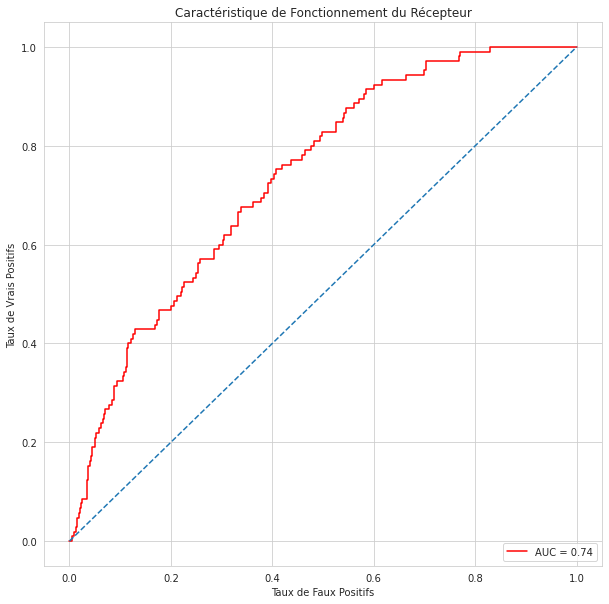

In [27]:
# Tracé des courbes ROC pour chaque modèle
for index, row in logistic_results.iterrows():
    fpr = row["fpr"]
    tpr = row["tpr"]
    roc_auc = row["roc_auc"]
    model_name = row["model"]
    dataset_name = row["dataset"]
    print('Courbe roc pour :', dataset_name)
    courbe_roc(fpr, tpr, roc_auc)

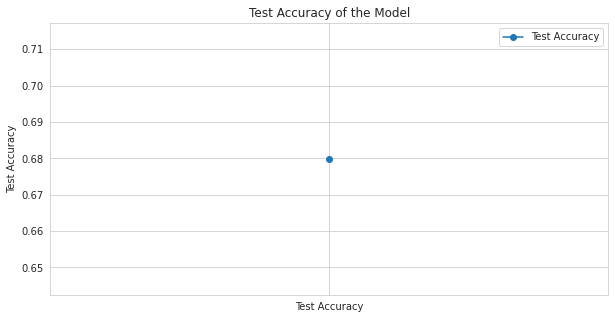

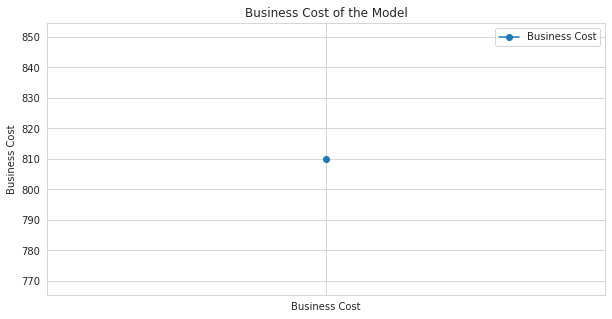

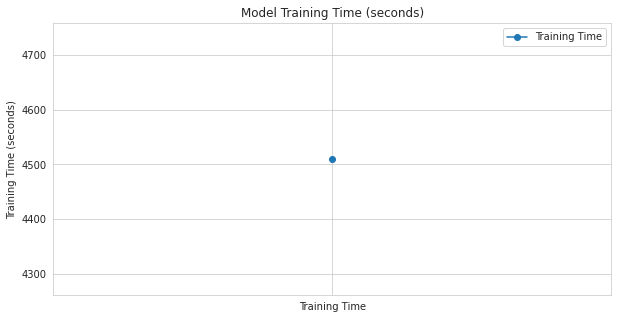

In [29]:
# Visualisation de la précision des tests
plt.figure(figsize=(10, 5))
plt.plot(['Test Accuracy'], logistic_results['test_accuracy'], marker='o', label='Test Accuracy')
plt.title("Test Accuracy of the Model")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()

# Visualisation du coût métier
plt.figure(figsize=(10, 5))
plt.plot(['Business Cost'], logistic_results['business_cost'], marker='o', label='Business Cost')
plt.title("Business Cost of the Model")
plt.ylabel("Business Cost")
plt.legend()
plt.show()

# Visualisation du temps d'entraînement
plt.figure(figsize=(10, 5))
plt.plot(['Training Time'], logistic_results['elapsed_time'], marker='o', label='Training Time')
plt.title("Model Training Time (seconds)")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()


**Conclusion :**

La modélisation effectuée avec la régression logistique sur le jeu de données 'filtered' a montré des résultats prometteurs.

Avec une précision d'entraînement de 70.63% et une précision de test de 67.98%, le modèle démontre une bonne généralisation, indiquant qu'il n'est pas en surajustement.

Les autres métriques, telles que le rappel, le score F1 et l'AUC-ROC, sont également satisfaisantes, bien que la précision soit relativement basse, ce qui pourrait nécessiter une investigation plus approfondie pour améliorer la capacité du modèle à identifier correctement les cas positifs.

L'utilisation de la validation croisée à 10 plis a contribué à renforcer la robustesse du modèle, en minimisant le risque de surajustement.

La présence d'un coût métier notable suggère que, bien que le modèle ait une bonne performance générale en termes de précision, de rappel, de score F1 et d'AUC-ROC, il y a encore de la place pour l'amélioration.

#### A. Interprétabilité Locale

L'interprétation locale des modèles consiste en un ensemble de techniques destinées à répondre à des questions telles que :

-Pourquoi le modèle a-t-il fait cette prédiction spécifique ?

-Quel a été l'impact de cette valeur de caractéristique spécifique sur la prédiction ?

**LIME** (Local Interpretable Model-Agnostic Explanations)

LIME est une technique qui permet de créer un modèle simple autour de la prédiction que nous voulons expliquer et utilise ce modèle simple pour donner une explication.

L'idée de base de LIME est assez simple. Pour une prédiction donnée, LIME perturbe les entrées de la prédiction et essaie de comprendre comment ces perturbations affectent la sortie du modèle. 

Les attributs qui affectent le plus la sortie lorsqu'ils sont perturbés sont considérés comme ayant une importance élevée pour cette prédiction spécifique.

In [30]:
feature_names = df_embedded_selected.columns.tolist() 

# Création de l'expliqueur LIME avec les noms des caractéristiques
explainer_lime = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=feature_names, class_names=['0', '1'], mode='classification')

i = 123 
exp = explainer_lime.explain_instance(X_test_scaled[i], best_log_reg.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)


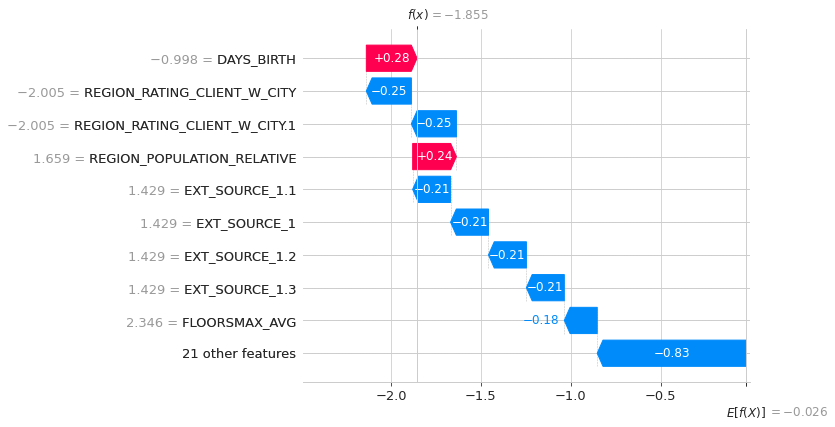

In [42]:
# Initialisation de SHAP
explainer_shap = shap.LinearExplainer(best_log_reg, X_train_scaled, feature_dependence="independent")

instance_index = 123  
selected_instance = X_test_scaled[instance_index]

# Calcul des valeurs SHAP pour l'instance sélectionnée
shap_values_instance = explainer_shap.shap_values(selected_instance)

expected_value_shap = explainer_shap.expected_value

feature_names = df_embedded_selected.columns.tolist()

# Création du waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values_instance, 
                                     base_values=expected_value_shap, 
                                     data=selected_instance, 
                                     feature_names=feature_names))


Les analyses via LIME et SHAP révèlent l'importance cruciale de l'âge du client, des facteurs démographiques régionaux et des scores de sources externes dans les prédictions du modèle. 

Malgré de légères différences, ces méthodes s'accordent sur le rôle majeur de ces caractéristiques.

LIME génère un modèle local interprétable autour d'une prédiction spécifique pour évaluer l'importance des caractéristiques. 

En contraste, SHAP utilise la théorie des jeux pour attribuer des valeurs de Shapley à chaque caractéristique, reflétant leur contribution moyenne à la prédiction sur toutes les combinaisons possibles de caractéristiques.

#### B. Interprétabilité Globale

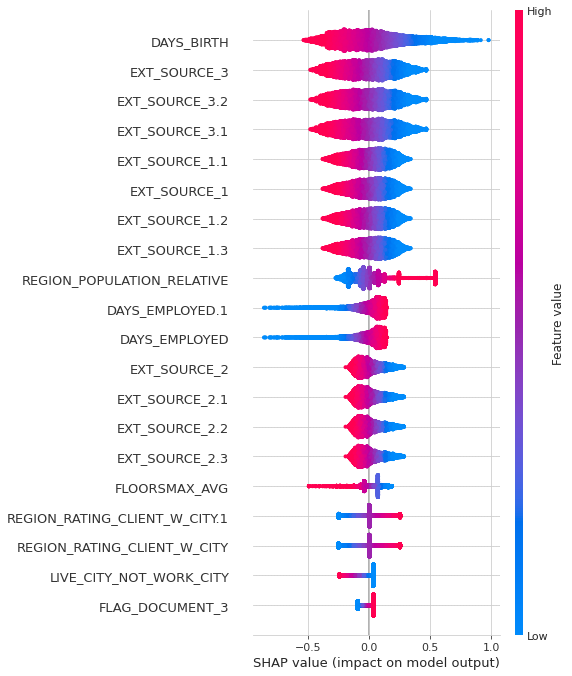

In [43]:
feature_names = df_embedded_selected.columns.tolist()

# Concaténation des ensembles de données d'entraînement et de test normalisés
X_full_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

# Création de SHAP
explainer_shap = shap.LinearExplainer(best_log_reg, X_train_scaled, feature_perturbation="interventional")

# Calcul des valeurs SHAP pour l'ensemble de données complet
shap_values = explainer_shap.shap_values(X_full_scaled)

shap.summary_plot(shap_values, X_full_scaled, feature_names=feature_names)

Cette visualisation révèle que l'âge du sujet, représenté par la variable DAYS_BIRTH, est le prédicteur le plus significatif, exerçant une influence prédominante sur l'issue prédite par le modèle. 

Les sources externes, notamment EXT_SOURCE_3 et ses dérivées, montrent une forte corrélation négative, indiquant que des valeurs élevées de ces caractéristiques tendent à diminuer la probabilité de l'événement étudié. 

La variabilité des impacts, indiquée par la dispersion des points, suggère une hétérogénéité des effets des variables sur les prédictions.

L'alignement des résultats entre la feature importance local et global attestent de la robustesse de ces variables comme déterminants prédictifs majeurs dans notre modèle de régression logistique.